# Model Development

In this notebook, we will develop a Kriging model using the `NYS Oil & Gas Wells` to predict optimal drilling locations for oil and gas in **New York State**. Using geological and production data, we will explore spatial interpolation techniques to accurately estimate potential production sites. The process will involve building the Kriging model and refining it through regularization and hyperparameter tuning.

By the end of this notebook, we will have established a robust model ready for evaluation, aiming to identify the most effective approach for predicting where to drill for oil and gas.

### Loading Tools and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy.signal import detrend
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from skgstat import Variogram, OrdinaryKriging
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk3d import UniversalKriging3D
from pykrige.rk import Krige
from gstools import SRF, Gaussian, Spherical, Exponential, krige
import pprint
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/clean_gaswells.csv')

### Log Transformation of Gas Production
It was essential for analysis that we put our gas production values in a smaller scale without losing its inherent value because various wells produced different amounts of gas (mcf / thousand cubic feet) and some wells produced a lot more than others. We couldn't remove these outliers because we want our model to predict on finding the wells that house the most gas.

In [2]:
df['gas_prod'] = np.log1p(df['gas_prod'])
print('gas_prod\n------------')
print(df['gas_prod'].describe())
print('gas_log1p\n------------')
print(pd.DataFrame(np.expm1(df[['gas_prod']])).describe())
df.rename(columns={'gas_prod':'gas_log1p'}, inplace=True)
print(df.info())

df_saved = df.copy()
df.head()

gas_prod
------------
count   7,377.00
mean        8.58
std         2.56
min         0.69
25%         7.68
50%         9.36
75%        10.36
max        16.19
Name: gas_prod, dtype: float64
gas_log1p
------------
           gas_prod
count      7,377.00
mean      30,034.74
std      205,015.66
min            1.00
25%        2,168.00
50%       11,610.00
75%       31,710.00
max   10,764,750.00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   gas_log1p  7377 non-null   float64
 1   well       7377 non-null   object 
 2   status     7377 non-null   object 
 3   depth      7377 non-null   float64
 4   elevation  7377 non-null   float64
 5   longitude  7377 non-null   float64
 6   latitude   7377 non-null   float64
 7   field      7377 non-null   object 
 8   geology    7377 non-null   object 
dtypes: float64(5), object(4)
memory usage: 518.8+ KB
None


,gas_log1p,well,status,depth,elevation,longitude,latitude,field,geology
0,3.56,oil development,active,"1,396.00","1,685.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
1,3.53,oil development,active,"1,280.00","1,640.00",-78.61,42.01,Bradford,Bradford Second
2,3.64,oil development,plugged abandoned,"1,505.00","1,870.00",-78.59,42.00,Bradford,"Chipmunk, Bradford 2nd & 3rd"
3,3.56,oil development,active,"1,486.00","1,850.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
4,3.56,oil development,active,"1,379.00","1,710.00",-78.61,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"


## Detrend

### Detrend Testing

#### Base Variogram - No Detrend

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 120209300.34496388,
 'normalized_sill': 1053.208335668646,
 'normalized_nugget': 0,
 'effective_range': 10964.000198146836,
 'sill': 29.004782872326782,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


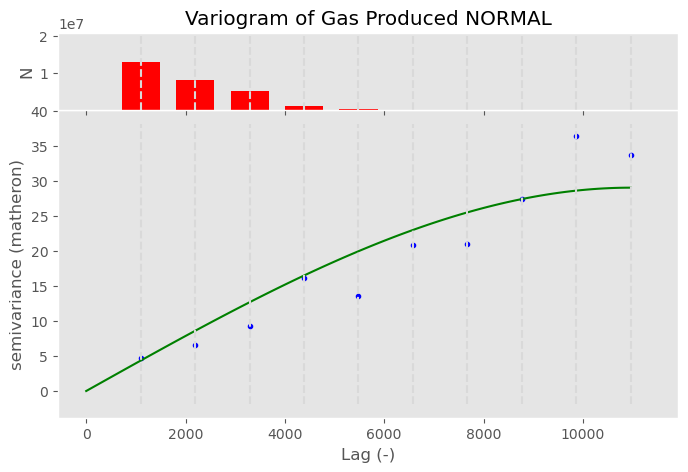

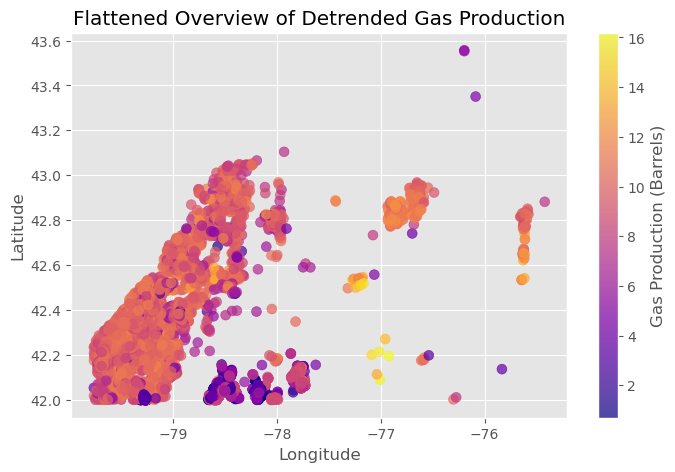

In [3]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

gas_variogram = Variogram(coordinates=coordinates, values=target)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced NORMAL')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(target), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Signal Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 120209300.34496388,
 'normalized_sill': 1131.2978521873708,
 'normalized_nugget': 0,
 'effective_range': 10964.000198146836,
 'sill': 30.198328103787382,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


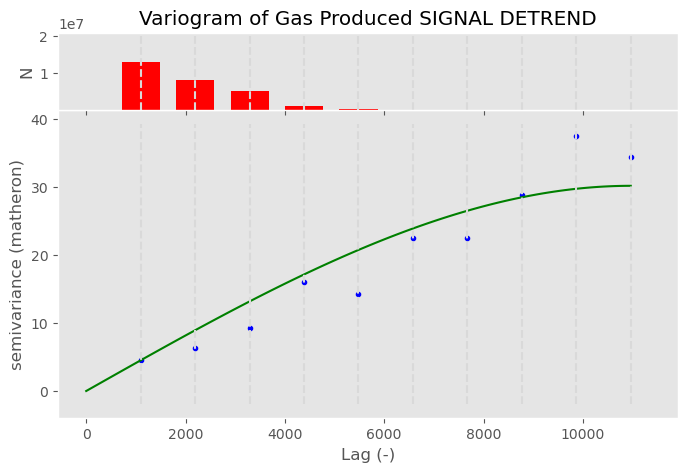

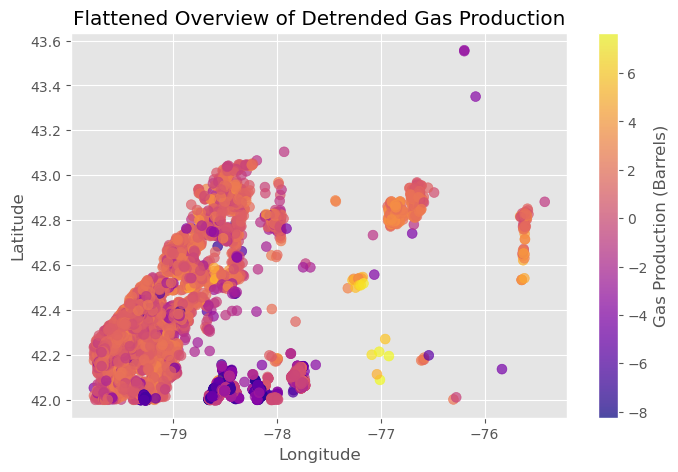

In [4]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

detrended_gas = detrend(target)

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced SIGNAL DETREND')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Pandas Diff Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 120209300.34496388,
 'normalized_sill': 868.5697617139068,
 'normalized_nugget': 0,
 'effective_range': 10964.000198146836,
 'sill': 27.271442970988847,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


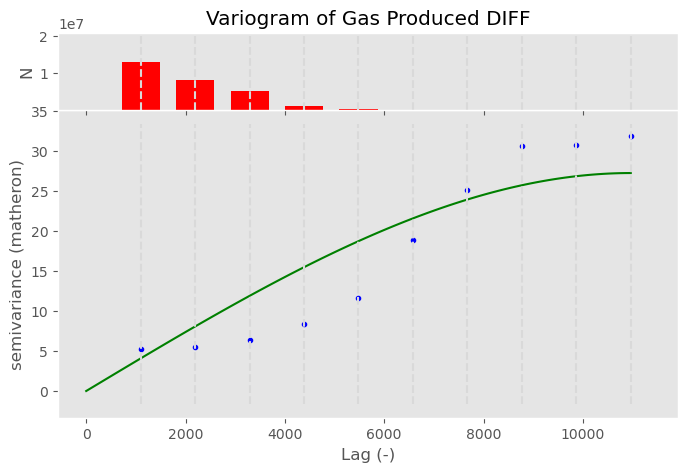

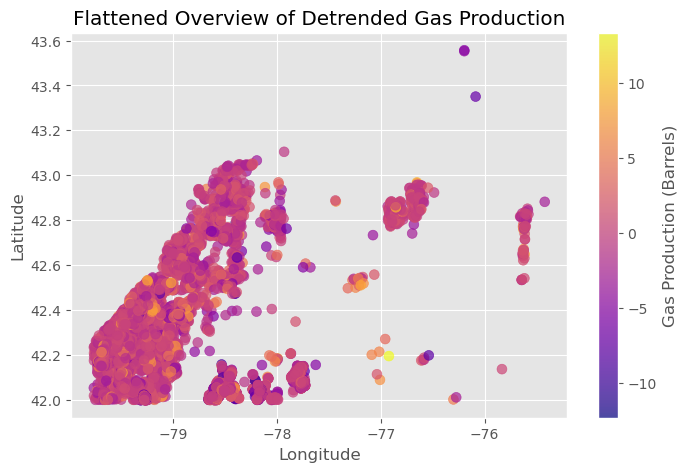

In [5]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

detrended_gas = df['gas_log1p'].diff().dropna()
coordinates = coordinates[1:]

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced DIFF')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude'][1:]), np.array(df['latitude'][1:]), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Linear Regression Detrended Variogram

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 120209300.34496388,
 'normalized_sill': 1733.9772774405099,
 'normalized_nugget': 0,
 'effective_range': 10964.000198146836,
 'sill': 28.203868907591087,
 'nugget': 0,
 'params': {'estimator': 'matheron',
            'model': 'spherical',
            'dist_func': 'euclidean',
            'bin_func': 'even',
            'normalize': False,
            'fit_method': 'trf',
            'fit_sigma': None,
            'use_nugget': False,
            'maxlag': None,
            'n_lags': 10,
            'verbose': False},
 'kwargs': {}}


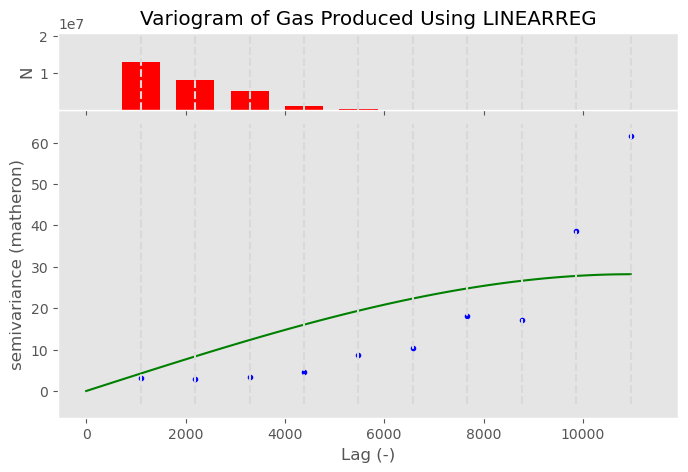

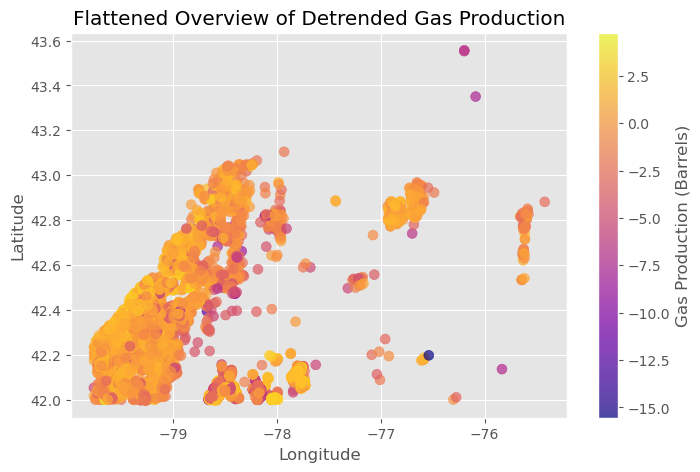

In [6]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

reg = LinearRegression().fit(coordinates, target)
trend = reg.predict(coordinates)
detrended_gas = target - trend

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pp(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using LINEARREG')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(np.array(df['longitude']), np.array(df['latitude']), 
                       s=50, c=np.array(detrended_gas), cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

#### Polynomial Regression Detrended Variogram

{'dist_func': 'euclidean',
 'effective_range': 10964.000198146836,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 120209300.34496388,
 'normalized_nugget': 0,
 'normalized_sill': 286.25207262666606,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 13.435263069186574}


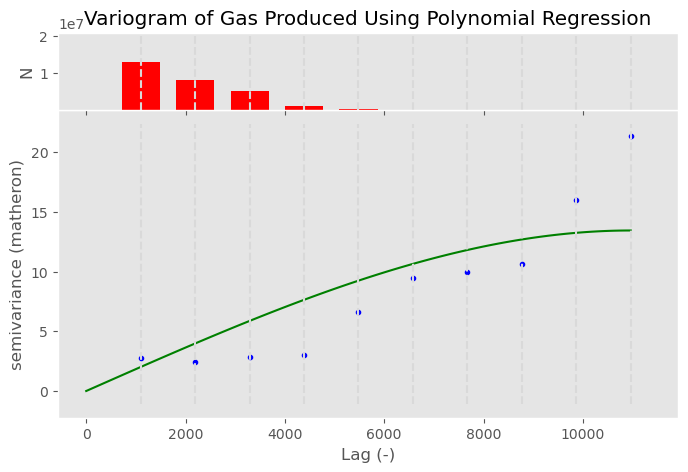

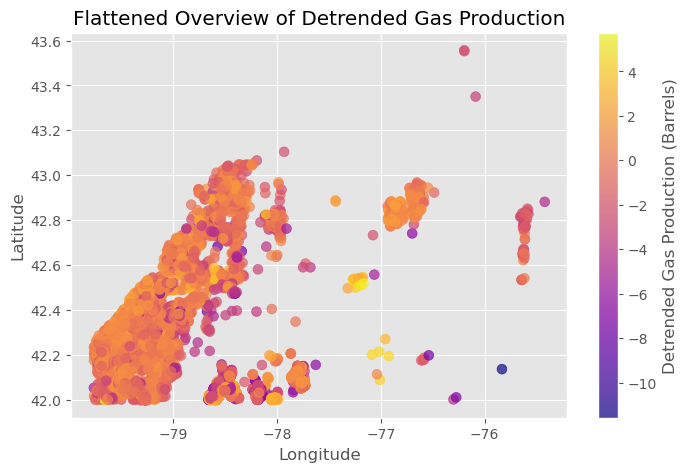

In [7]:
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

poly = PolynomialFeatures(degree=2, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pprint(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=detrended_gas, cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

### Detrend Preprocessing

##### `Polynomial regression is the best method for detrending as shown by the sill of 13, which is comparable to the linear regression at 28. Although the polynomial regression exhibited a more significant drop in sill value compared to the linear regression, the variogram still shows a gradual increase in semivariance as lag distance increases. This suggests that despite the reduction in correlation, the polynomial regression still retains a sense of spatial correlation that appears genuine and reflective of the true underlying spatial structure.`

#### Detrend Build

In [8]:
df_original = df_saved.copy()
df_detrended = df_saved.copy()
df = df_saved.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p'])

poly = PolynomialFeatures(degree=2, include_bias=False)
coordinates_poly = poly.fit_transform(coordinates)

reg = LinearRegression().fit(coordinates_poly, target)
trend = reg.predict(coordinates_poly)
detrended_gas = target - trend

min_value = detrended_gas.min()
constant = abs(min_value) + 1
shifted_detrended_gas = detrended_gas + constant

df_detrended['gas_log1p'] = shifted_detrended_gas
df_detrended.rename(columns={'gas_log1p':'gas_log1p_dtsft'}, inplace=True)
print(df_detrended.describe())
df_detrended

       gas_log1p_dtsft     depth  elevation  longitude  latitude
count         7,377.00  7,377.00   7,377.00   7,377.00  7,377.00
mean             12.58  2,559.31   1,462.73     -78.73     42.31
std               1.65  1,219.57     455.58       0.75      0.29
min               1.00    181.00       8.00     -79.76     42.00
25%              11.81  1,580.00   1,210.00     -79.27     42.05
50%              12.83  2,316.00   1,520.00     -78.88     42.20
75%              13.59  3,600.00   1,770.00     -78.46     42.51
max              18.32 11,145.00   2,576.00     -75.42     43.56


,gas_log1p_dtsft,well,status,depth,elevation,longitude,latitude,field,geology
0,10.50,oil development,active,"1,396.00","1,685.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
1,10.71,oil development,active,"1,280.00","1,640.00",-78.61,42.01,Bradford,Bradford Second
2,10.40,oil development,plugged abandoned,"1,505.00","1,870.00",-78.59,42.00,Bradford,"Chipmunk, Bradford 2nd & 3rd"
3,10.32,oil development,active,"1,486.00","1,850.00",-78.60,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
4,10.53,oil development,active,"1,379.00","1,710.00",-78.61,42.01,Bradford,"Chipmunk, Bradford 2nd & 3rd"
...,...,...,...,...,...,...,...,...,...
7372,13.57,gas development,active,"2,066.00",630.00,-76.64,42.90,West Auburn,Queenston
7373,11.48,gas extension,active,"2,393.00",770.00,-76.58,42.88,West Auburn,Queenston
7374,13.79,gas extension,active,"2,540.00",838.00,-76.61,42.85,West Auburn,Queenston
7375,13.69,gas extension,active,"2,487.00",825.00,-76.63,42.84,West Auburn,Queenston


#### Detrend Plot

{'dist_func': 'euclidean',
 'effective_range': 10964.000198146836,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 120209300.34496388,
 'normalized_nugget': 0,
 'normalized_sill': 286.25207262666606,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'trf',
            'fit_sigma': None,
            'maxlag': None,
            'model': 'spherical',
            'n_lags': 10,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 13.435263069186574}


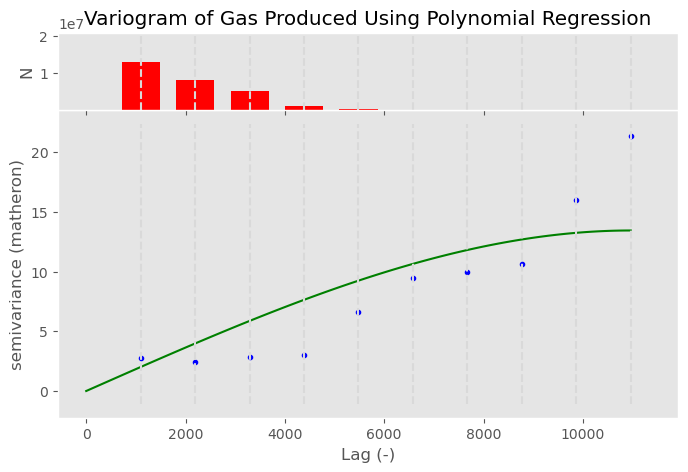

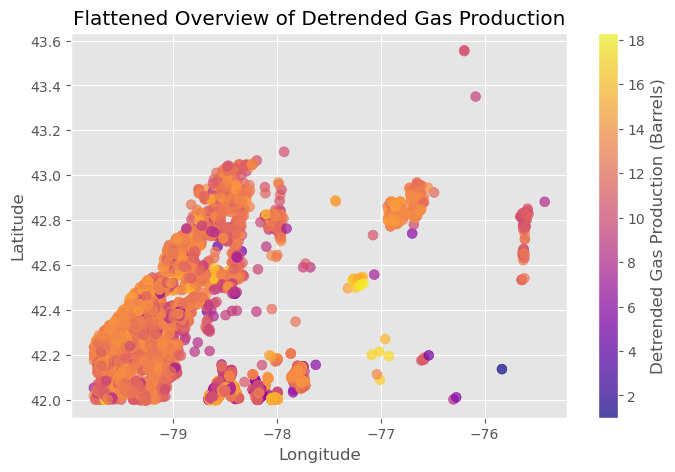

In [9]:
df = df_detrended.copy()
coordinates = np.array(df[['longitude', 'latitude', 'depth']])
target = np.array(df['gas_log1p_dtsft'])

gas_variogram = Variogram(coordinates=coordinates, values=detrended_gas)
pprint.pprint(gas_variogram.describe())

gas_variogram.plot()
plt.title('Variogram of Gas Produced Using Polynomial Regression')
plt.show()
plt.close()

fig, ax = plt.subplots(1, figsize=(8,5))
corr_plot = ax.scatter(df['longitude'], df['latitude'], 
                       s=50, c=df['gas_log1p_dtsft'], cmap='plasma', alpha=0.7)
plt.colorbar(corr_plot).set_label('Detrended Gas Production (Barrels)')
plt.title('Flattened Overview of Detrended Gas Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.close()

## Kriging Models

### Model Preparation

In [10]:
df = df_detrended.copy()
train, test = train_test_split(df, test_size=0.25, random_state=42)

x_train = np.array(train['longitude'].values)
y_train = np.array(train['latitude'].values)
h_train = np.array(train['depth'].values)
v_train = np.array(train['gas_log1p_dtsft'].values)

x_test = np.array(test['longitude'].values)
y_test = np.array(test['latitude'].values)
h_test = np.array(test['depth'].values)
v_test = np.array(test['gas_log1p_dtsft'].values)

gridx_train = np.linspace(x_train.min(), x_train.max(), 50)
gridy_train = np.linspace(y_train.min(), y_train.max(), 50)
gridh_train = np.linspace(h_train.min(), h_train.max(), 50)

gridx_test = np.linspace(x_test.min(), x_test.max(), 50)
gridy_test = np.linspace(y_test.min(), y_test.max(), 50)
gridh_test = np.linspace(h_test.min(), h_test.max(), 50)

print(f'\
train_test_split shapes\n------------\n\
x_train: {x_train.shape}\n\
y_train: {y_train.shape}\n\
h_train: {h_train.shape}\n\
v_train: {v_train.shape}\n\
x_test: {x_test.shape}\n\
y_test: {y_test.shape}\n\
h_test: {h_test.shape}\n\
v_test: {v_test.shape}')

train_test_split shapes
------------
x_train: (5532,)
y_train: (5532,)
h_train: (5532,)
v_train: (5532,)
x_test: (1845,)
y_test: (1845,)
h_test: (1845,)
v_test: (1845,)


## Preprocessing

In [11]:
df.columns

Index(['gas_log1p_dtsft', 'well', 'status', 'depth', 'elevation', 'longitude',
       'latitude', 'field', 'geology'],
      dtype='object')

In [12]:
df.well.unique()

array(['oil development', 'gas development', 'oil wildcat',
       'gas extension', 'dry wildcat', 'gas wildcat', 'oil extension'],
      dtype=object)

In [13]:
df.status.unique()

array(['active', 'plugged abandoned', 'inactive', 'shut in',
       'drilling complete'], dtype=object)

In [14]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import train_test_split

# # Assuming 'df' is your DataFrame with all required columns
# target = df['gas_log1p_dtsft']
# ordinal = [
# categorical_features = ['well', 'status', 'field', 'geology']
# numerical_features = ['depth', 'elevation', 'longitude', 'latitude']

# # Preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', MinMaxScaler())
#         ]), numerical_features),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('onehot', OneHotEncoder(handle_unknown='ignore'))
#         ]), categorical_features)
#     ])

# # Add the preprocessor into your pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# # Split data into train and test sets
# X = df.drop(columns=['gas_log1p_dtsft'])  # Drop target variable
# y = df['gas_log1p_dtsft']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Fit the pipeline
# pipeline.fit(X_train)

# # Transform the data
# X_train_transformed = pipeline.transform(X_train)
# X_test_transformed = pipeline.transform(X_test)

# # Now you have preprocessed data ready for kriging


### Ordinary Kriging

In [15]:
# ok = OrdinaryKriging(
#     x_train,
#     y_train,
#     v_train,
#     variogram_model='linear',
#     verbose=True,
#     enable_plotting=True )

# z_train, s2_train = ok.execute("grid", gridx_train, gridy_train)
# z_test, s2_test = ok.execute('grid', gridx_test, gridy_test)
# pred, error = ok.execute('points', x_test, y_test)

# rmse = np.sqrt(mean_squared_error(actual, pred))
# mae = mean_absolute_error(actual, pred)
# r2 = r2_score(actual, pred)

# print('\n------------\n')
# print("RMSE:", round(rmse,3))
# print("MAE:", round(mae,3))
# print("R2:", round(r2,3))
# print('\n------------\n')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# im1 = ax1.imshow(z_train, cmap='plasma', interpolation='bilinear', vmin=z_train.min(), vmax=z_train.max(),
#                  extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
# ax1.set_title('Kriging Interpolation (Train)')
# ax1.plot(x_train, y_train, 'w+')
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Latitude')
# plt.colorbar(im1, ax=ax1, label='Gas Production')

# im2 = ax2.imshow(s2_train, cmap='YlGn_r', interpolation='bilinear',
#                  extent=(gridx_train.min(), gridx_train.max(), gridy_train.min(), gridy_train.max()), origin='lower')
# ax2.set_title('Kriging Error (Train)')
# ax2.plot(x_train, y_train, 'w+')
# ax2.set_xlabel('Longitude')
# ax2.set_ylabel('Latitude')
# plt.colorbar(im2, ax=ax2, label='Error')

# plt.show()
# plt.close()

## Script

In [16]:
try:
    print('Script executed successfully.')
except:
    print('FAILED')

Script executed successfully.
